# Calibrate AVHRR NDVI to match MODIS NDVI


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump
from scipy import stats
import geopandas as gpd
from pprint import pprint
import contextily as ctx
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import lightgbm as lgbm
from lightgbm import LGBMRegressor

import shap
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

import warnings
warnings.filterwarnings("ignore")

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Analysis parameters


In [2]:
model_var='LST' #NDVI or LST
n_samples = 30000
n_val = 5000
name = 'AUS' #trees nontrees AUS (for LST)
feat = 'NOCLIM'
t1 = '1982'
t2 = '2013'

base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Assemble datasets for training and predicting

### Clean/filter AVHRR data

In [3]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')
ds = assign_crs(ds, crs ='epsg:4326')
ds = round_coords(ds)

if model_var=='LST':
    ds = ds.rename({'VZA_median':'SZEN_median'})

In [4]:
before_fraction_avail = (~np.isnan(ds[model_var+'_avhrr'])).sum('time')/len(ds.time)

In [5]:
#filter by num of obs/month
ds = ds.where(ds['n_obs']>=2)

#remove any very low NDVI vals
if model_var=='NDVI':
    ds = ds.where(ds[model_var+'_avhrr']>=0.01)

# filter by coefficient of variation each month
ds[model_var+'_cv'] = ds[model_var+'_stddev'] / ds[model_var+'_avhrr']
ds = ds.where(ds[model_var+'_cv']<0.5)

#filter by large std dev anomalies
def stand_anomalies(ds, clim_mean, clim_std):
    std_anom = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
    ds.compute().groupby("time.month"),
    clim_mean, clim_std)
    return std_anom

#calculate anomalies
clim_std = ds.groupby('time.month').std()
clim = ds.groupby('time.month').mean()
std_anom = stand_anomalies(ds, clim, clim_std)

#create masks where values are < 4 stddev >
anom_mask = xr.where((std_anom[model_var+'_avhrr'] > -4) & (std_anom[model_var+'_avhrr'] < 4), 1, 0)
sza_anom_mask = xr.where((std_anom['SZEN_median'] > -4) & (std_anom['SZEN_median'] < 4), 1, 0)
tod_anom_mask = xr.where((std_anom['TIMEOFDAY_median'] > -4) & (std_anom['TIMEOFDAY_median'] < 4), 1, 0)
ds = ds.where(anom_mask)
ds = ds.where(sza_anom_mask)
ds = ds.where(tod_anom_mask)

### drop late-1993 and 1994 due to sensor change at NOAA 11 - 14
_1994 = ds.sel(time=slice('1993-06', '1994-12'))
_1994 = _1994.where(_1994['NDVI_avhrr']<-1, np.nan)
times_to_drop = ds.time.sel(time=slice('1993-06', '1994-12'))
ds = ds.drop_sel(time=times_to_drop)
ds = xr.concat([ds, _1994], dim='time').sortby('time')

### drop Nov1988 - Oct 1989 due to sensor degraedation at change over
### from NOAA 9 to 11
_1988 = ds.sel(time=slice('1988-11', '1989-10'))
_1988 = _1988.where(_1988['NDVI_avhrr']<-1, np.nan)
times_to_drop = ds.time.sel(time=slice('1988-11', '1989-10'))
ds = ds.drop_sel(time=times_to_drop)
ds = xr.concat([ds, _1988], dim='time').sortby('time')

### Plot available fraction of data before/after filtering

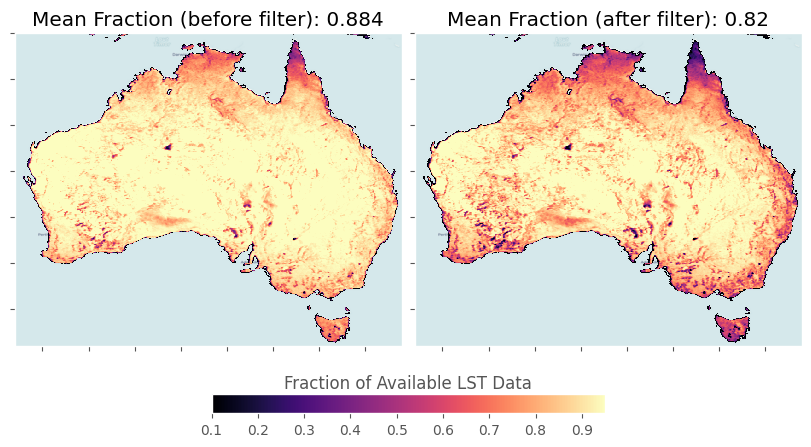

In [6]:
after_fraction_avail = (~np.isnan(ds[model_var+'_avhrr'])).sum('time')/len(ds.time)

fract_avail_mask = xr.where(before_fraction_avail>0, 1, 0)
after_fraction_avail = after_fraction_avail.where(fract_avail_mask)
before_fraction_avail = before_fraction_avail.where(fract_avail_mask)

fig,ax=plt.subplots(1,2, figsize=(8,5),sharey=True, layout='constrained')

im = before_fraction_avail.rename('').plot(vmin=0.1, vmax=0.95, ax=ax[0], cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
im = after_fraction_avail.rename('').plot(vmin=0.1, vmax=0.95, ax=ax[1], cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

ax[0].set_title('Mean Fraction (before filter): '+str(round(before_fraction_avail.mean().values.item(), 3)));
ax[1].set_title('Mean Fraction (after filter): '+str(round(after_fraction_avail.mean().values.item(), 3)))

ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

cb = fig.colorbar(im, ax=ax, shrink=0.5, orientation='horizontal', label='Fraction of Available '+model_var+' Data');
cb.ax.xaxis.set_label_position('top')

fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/AVHRR_"+model_var+"_fraction_available.png",
            bbox_inches='tight', dpi=300)

### export filtered mask

In [7]:
filtered_mask = ~np.isnan(ds[model_var+'_avhrr'])
filtered_mask = filtered_mask.drop('month')
filtered_mask.to_netcdf(base+model_var+'_harmonization/AVHRR_'+model_var+'_filtered_mask_1982_2013.nc')

### Add lagged features

In [8]:
# ds[model_var+'_avhrr_1f'] = ds[model_var+'_avhrr'].shift(time=1)
# ds[model_var+'_avhrr_1b'] = ds[model_var+'_avhrr'].shift(time=-1)
# ds['NDVI_avhrr_2f'] = ds['NDVI_avhrr'].shift(time=2)
# ds['NDVI_avhrr_2b'] = ds['NDVI_avhrr'].shift(time=-2)

In [9]:
ds = ds.sel(time=slice(t1, t2))
ds = ds.drop('month')

### Open covariables

In [10]:
if model_var=='NDVI':
    
        if feat=='CLIM':
            datasets =[
                model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc',
                '5km/MOY_5km_monthly_1982_2022.nc',
                '5km/srad_5km_monthly_1982_2022.nc',
                '5km/srad_anom_5km_monthly_1982_2022.nc',
                '5km/rain_cml3_5km_monthly_1982_2022.nc',
                '5km/rain_cml3_anom_5km_monthly_1982_2022.nc',
                   ]
        if feat=='NOCLIM': 
            datasets =[
                model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc',
                '5km/MOY_5km_monthly_1982_2022.nc'
                    ]

if model_var=='LST':
    
    if feat=='CLIM':
        datasets = [
            model_var+'_harmonization/MODIS_'+model_var+'_MYD21A1D_5km_monthly_200207_202212.nc',
            '5km/MOY_5km_monthly_1982_2022.nc',
            '5km/srad_5km_monthly_1982_2022.nc',
            '5km/srad_anom_5km_monthly_1982_2022.nc',
            '5km/tavg_5km_monthly_1982_2022.nc',
            '5km/tavg_anom_5km_monthly_1982_2022.nc',
                   ]
    
    if feat=='NOCLIM':
        datasets = [
            model_var+'_harmonization/MODIS_'+model_var+'_MYD21A1D_5km_monthly_200207_202212.nc',
            '5km/MOY_5km_monthly_1982_2022.nc'
                   ]

In [11]:
dss = []
names = []
for d in datasets:
    xx =  assign_crs(xr.open_dataset(base+d),crs='epsg:4326').sel(time=slice(t1,t2))
    xx = xx.drop('spatial_ref')
    xx = round_coords(xx)
    names.append(list(xx.data_vars)[0])
    dss.append(xx.transpose('time', 'latitude', 'longitude'))

covars = xr.merge(dss)
covars = assign_crs(covars, crs ='epsg:4326')
covars = covars.rename({model_var+'_median':model_var+'_modis'})

#merge the AVHR with covariables
ds = xr.merge([ds,covars])

### Add some MODIS summary stats

In [12]:
mean_modis = ds[model_var+'_modis'].median('time')
mean_modis = mean_modis.expand_dims(time=ds.time)
ds[model_var+'_modis_median'] = mean_modis

min_modis = ds[model_var+'_modis'].quantile(0.05, dim='time').drop('quantile')
min_modis = min_modis.expand_dims(time=ds.time)
ds[model_var+'_modis_min'] = min_modis

max_modis = ds[model_var+'_modis'].quantile(0.95, dim='time').drop('quantile')
max_modis = max_modis.expand_dims(time=ds.time)
ds[model_var+'_modis_max'] = max_modis

#remove unneeded variables
ds = ds.drop([model_var+'_stddev', 'n_obs', model_var+'_cv'])

In [13]:
ds

<xarray.Dataset>
Dimensions:           (time: 384, latitude: 680, longitude: 840)
Coordinates:
    spatial_ref       int32 4326
  * latitude          (latitude) float32 -10.02 -10.07 -10.12 ... -43.92 -43.97
  * longitude         (longitude) float32 112.0 112.1 112.1 ... 153.9 154.0
  * time              (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2013-12-15
Data variables:
    LST_avhrr         (time, latitude, longitude) float32 nan nan ... nan nan
    TIMEOFDAY_median  (time, latitude, longitude) float32 nan nan ... nan nan
    SZEN_median       (time, latitude, longitude) float32 nan nan ... nan nan
    LST_modis         (time, latitude, longitude) float32 nan nan ... nan nan
    month             (time, latitude, longitude) float32 ...
    LST_modis_median  (time, latitude, longitude) float32 nan nan ... nan nan
    LST_modis_min     (time, latitude, longitude) float32 nan nan ... nan nan
    LST_modis_max     (time, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    nodata:   nan

### Add derivative of rainfall

In [14]:
# derived = ds['rain'].differentiate(coord='time', datetime_unit='D')
# ds['rain_gradient'] = derived
# corr= xr.corr(ds['LST_modis'], ds['LST_avhrr'], dim='time')

### Mask for trees/no-trees mask

In [15]:
# if model_var=='NDVI'
trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

if model_var=='NDVI':
    if name=='trees':
        mask = xr.where(trees>0.25, 1, 0)
    if name=='nontrees':
        mask = xr.where(trees<=0.25, 1, 0)

if model_var=='LST':
    if name=='AUS':
        mask = xr.where(trees>=0, 1, 0) # set everywhere as valid

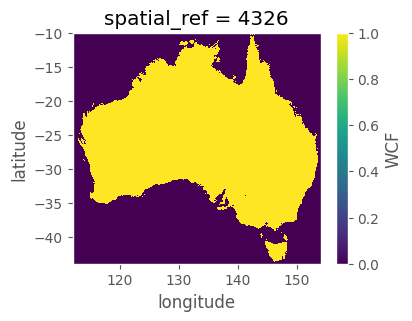

In [16]:
mask.plot(size=3)

In [17]:
ds = ds.where(filtered_mask) # mask covariables with avhhr filtered
ds = ds.where(mask) # mask trees/notrees

## Training & testing data: equal random sampling of bioclimatic regions

Can skip to importing TD if already run this

In [18]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [19]:
# Dictionary to save results 
results = []
for index, row in gdf.iterrows():

    if name=='trees':
        n=int(n_samples/5)
    
    if name=='nontrees':
        n=int(n_samples/6)

    if name=='AUS':
        n=int(n_samples/6)
        
    if (name=='trees') & (row['region_name']=='Desert'):
        continue

    # else:
    print(row['region_name'], n)
    
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = ds.sel(time=slice('2000-03','2013')).where(mask)
    
    #sample equivalent num of samples per region
    df = dss.to_dataframe().dropna().sample(n=n, random_state=0).reset_index()
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.append(df)


Tropics 5000
Savanna 5000
Warm Temperate 5000
Cool Temperate 5000
Mediterranean 5000
Desert 5000


In [20]:
df = pd.concat(results).reset_index(drop=True)
df['year'] = pd.DatetimeIndex(df['time']).year

In [21]:
df = df.drop(['time','spatial_ref'], axis=1)

### Independent validation samples

In [22]:
validation = df.sample(n=n_val, random_state=0)

In [23]:
df = df.drop(validation.index)
print(len(df), 'training samples')

25000 training samples


### Plot the location of the samples

In [24]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

gdf_val = gpd.GeoDataFrame(
    validation, geometry=gpd.points_from_xy(validation.longitude, validation.latitude), crs="EPSG:4326"
)

gdf.to_file(f'/{base}{model_var}_harmonization/LGBM/{model_var}_{name}_{feat}_training_data.geojson')
gdf_val.to_file(f'{base}{model_var}_harmonization/LGBM/{model_var}_{name}_{feat}_validation_data.geojson')

<Axes: >

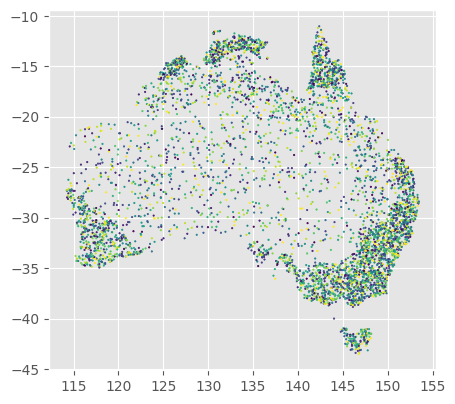

In [25]:
gdf = gdf.drop(['longitude'], axis=1)
gdf_val = gdf_val.drop(['longitude'], axis=1)

# gdf.explore(column='year', cmap='inferno')
gdf_val.plot(column='year', figsize=(5,5), markersize=1)

In [26]:
# gdf = gpd.read_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/'+model_var+'_training_data.geojson')
# gdf_val = gpd.read_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/'+model_var+'_validation_data.geojson')

### Prepare data for training

In [27]:
df = pd.DataFrame(gdf.drop(columns='geometry', axis=1))
validation = pd.DataFrame(gdf_val.drop(columns='geometry', axis=1))

df = df.drop(['year'], axis=1)
validation = validation.drop(['year'], axis=1)

y = df[model_var+'_modis']
x = df.drop([model_var+'_modis'], axis=1)

## Testing model using nested CV

In [28]:
# Create the parameter grid using distributions
param_grid = {
    'num_leaves': stats.randint(5,50),
    'min_child_samples':stats.randint(10,30),
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': stats.randint(5,25),
    'n_estimators': [300, 400, 500],
}

In [29]:
outer_cv = KFold(n_splits=5, shuffle=True,
                   random_state=0)

# lists to store results of CV testing
acc = []
rmse=[]
r2=[]

i = 1
for train_index, test_index in outer_cv.split(x, y):
    print(f"Working on {i}/5 outer CV split", end='\r')
    model = LGBMRegressor(random_state=1,
                          verbose=-1,
                          # n_jobs=-1
                          )

    # index training, testing
    X_tr, X_tt = x.iloc[train_index, :], x.iloc[test_index, :]
    y_tr, y_tt = y.iloc[train_index], y.iloc[test_index]
    
    #simple random split on inner fold
    inner_cv = KFold(n_splits=3,
                     shuffle=True,
                     random_state=0)
    
    clf = RandomizedSearchCV(
                   model,
                   param_grid,
                   verbose=0,
                   n_iter=50,
                   # n_jobs=-1,
                   cv=inner_cv.split(X_tr, y_tr)
                  )
    
    #prevents extensive print statements
    clf.fit(X_tr, y_tr, callbacks=None)
    
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # MAE
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # RMSE
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    
    #1:1 plots for each fold (save to csv so we can make a plot later on)
    df = pd.DataFrame({'Test':y_tt, 'Pred':pred}).reset_index(drop=True)

    df.to_csv(f'{base}{model_var}_harmonization/cross_validation/{i}_{model_var}_lgbm_{name}_{feat}.csv')
    
    i += 1

### Create a single 1:1 plot out of the folds 


In [30]:
dffs=[]
for i in range(1,5+1):
    df = pd.read_csv(f'{base}{model_var}_harmonization/cross_validation/{i}_{model_var}_lgbm_{name}_{feat}.csv',
                     usecols=['Test', 'Pred'])
    dffs.append(df)

cross_df = pd.concat(dffs)

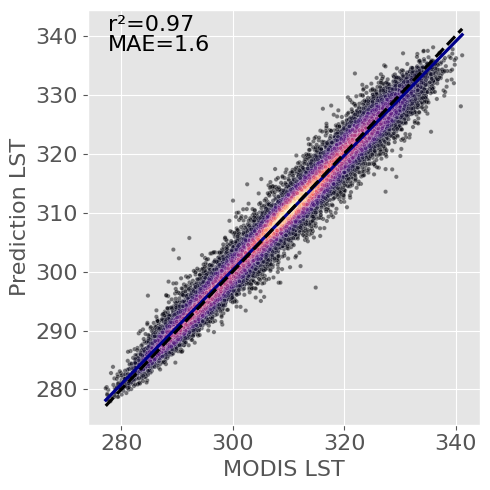

In [31]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

xy = np.vstack([cross_df['Test'],cross_df['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=cross_df, x='Test',y='Pred', cmap='magma', c=z, s=10, lw=1, alpha=0.5, ax=ax)
sb.regplot(data=cross_df, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=cross_df, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
# plt.colorbar()
plt.xlabel('MODIS '+model_var, fontsize=16)
plt.ylabel('Prediction '+model_var, fontsize=16)
ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=16)
ax.text(.05, .9, 'MAE={:.2g}'.format(np.mean(acc)),
            transform=ax.transAxes, fontsize=16)

if model_var=='NDVI':
    ax.set_ylim(0.0, 0.95)
    ax.set_xlim(0.0, 0.95)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
fig.savefig(f'{base}{model_var}_harmonization/cross_validation/cross_val_{model_var}_lgbm_{name}_{feat}.png',
            bbox_inches='tight', dpi=300)

### Optimize model using all training data

Using a randomized strategy so we can search through more variables, with 500 iterations


In [32]:
outer_cv = KFold(n_splits=5, shuffle=True,
                   random_state=0)

clf = RandomizedSearchCV(LGBMRegressor(verbose=-1),
                   param_grid,
                   verbose=1,
                   n_iter=250,
                   # n_jobs=-1,
                   cv=outer_cv
                  )

clf.fit(x, y, callbacks=None)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=LGBMRegressor(verbose=-1), n_iter=250,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1534ad96e820>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1534ad952ee0>,
                                        'n_estimators': [300, 400, 500],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1534ad1fb340>},
                   verbose=1)

In [33]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The best score using these parameters is: ")
print(round(clf.best_score_, 2))

The most accurate combination of tested parameters is: 
{'boosting_type': 'gbdt',
 'max_depth': 10,
 'min_child_samples': 23,
 'n_estimators': 500,
 'num_leaves': 23}


The best score using these parameters is: 
0.97


### Fit on all data using best params

In [34]:
model = LGBMRegressor(**clf.best_params_)

model.fit(x,y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 25000, number of used features: 8
[LightGBM] [Info] Start training from score 309.073694


LGBMRegressor(max_depth=10, min_child_samples=23, n_estimators=500,
              num_leaves=23)

## Compare with independent validation data

In [35]:
y_val = validation[model_var+'_modis']
x_val = validation.drop([model_var+'_modis'], axis=1)

In [36]:
pred = model.predict(x_val)

r2 = r2_score(y_val, pred)
ac = mean_absolute_error(y_val, pred)
df_val = pd.DataFrame({'Test':y_val, 'Pred':pred}).reset_index(drop=True)

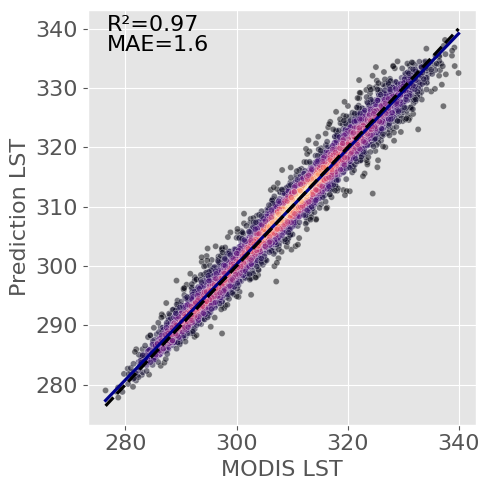

In [37]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

xy = np.vstack([df_val['Test'],df_val['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=df_val, x='Test',y='Pred', cmap='magma', c=z, s=20, lw=1, alpha=0.5, ax=ax, legend=True)
sb.regplot(data=df_val, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=df_val, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);

plt.xlabel('MODIS '+model_var, fontsize=16)
plt.ylabel('Prediction '+model_var, fontsize=16)
ax.text(.05, .95, 'R\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=16)
ax.text(.05, .9, 'MAE={:.2g}'.format(ac),
            transform=ax.transAxes, fontsize=16)

if model_var=='NDVI':
    ax.set_ylim(0.05, 0.95)
    ax.set_xlim(0.05, 0.95)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
fig.savefig(f'{base}{model_var}_harmonization/cross_validation/validation_{model_var}_lgbm_{name}_{feat}.png',
            bbox_inches='tight', dpi=300)

### Save the model

In [38]:
dump(model, f'{base}{model_var}_harmonization/LGBM/Harmonization_LGBM_{name}_{feat}.joblib')

['/g/data/os22/chad_tmp/climate-carbon-interactions/data/LST_harmonization/LGBM/Harmonization_LGBM_AUS_NOCLIM.joblib']

### Examine feature importance using SHAP


In [39]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

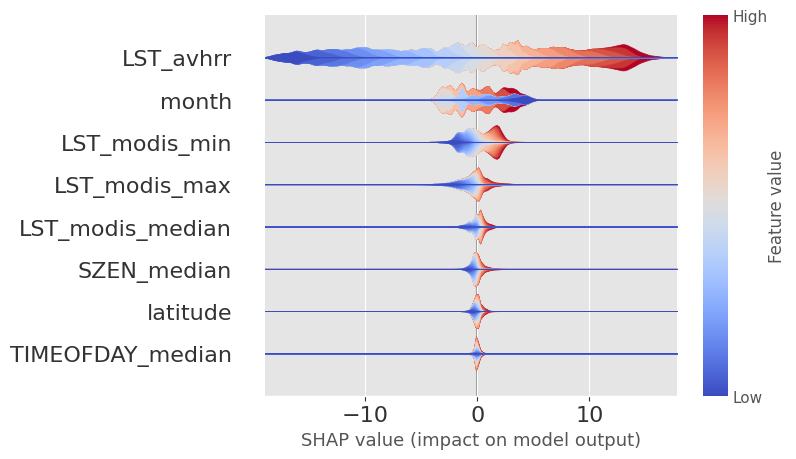

In [40]:
fig, ax = plt.subplots(1,1, figsize=(5,7))
shap.plots.violin(shap_values, max_display=10, show=False, plot_type="layered_violin")
ax = plt.gca() 
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(15)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

if name=='trees':
    ax.set_xlabel(model_var+ ' "Trees" '+'SHAP Value', fontsize=16)
    ax.set_xlim(-0.1, 0.1)
if name=='nontrees':
    ax.set_xlabel(model_var+ ' "Non-Trees" '+'SHAP Value', fontsize=16)
    ax.set_xlim(-0.2, 0.2)
plt.tight_layout()
fig.savefig(f'{base}{model_var}_harmonization/cross_validation/feature_importance_{model_var}_lgbm_{name}_{feat}.png',
            bbox_inches='tight', dpi=300)

## Predict

In [41]:
from datacube.utils.dask import start_local_dask

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.classification import predict_xr, HiddenPrints

In [42]:
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200468745216 due to system memory limit of 95.00 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41887,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:43723,Total threads: 24
Dashboard: /proxy/41183/status,Memory: 95.00 GiB
Nanny: tcp://127.0.0.1:37877,


### Load model

In [43]:
# model = load(f'{base}{model_var}_harmonization/Harmonization_LGBM_{name}_{feat}.joblib').set_params(n_jobs=1)

### Add lat as a variable

Plus ensure order of the variables is correct for predictions

In [44]:
y = ds.latitude
y = y.expand_dims(time=ds.time, longitude=ds.longitude)
y = y.transpose('time', 'latitude', 'longitude')
ds['latitude_data'] = y

# lon = ds.longitude
# lon = lon.expand_dims(time=ds.time, latitude=ds.latitude)
# lon = lon.transpose('time', 'latitude', 'longitude')
# ds['longitude_gridded'] = lon

### Ensure features match

In [45]:
columns = list(ds.data_vars)[:-1]
columns.insert(0, 'latitude_data')
ds = ds[columns]
ds = ds.drop(model_var+'_modis')

In [46]:
train_vars = list(x.columns)
train_vars[0] = 'latitude_data'

if train_vars == list(ds.data_vars):
    print('Variables match, n: ', len(ds.data_vars))
else:
    raise ValueError('Variables dont match')

Variables match, n:  8


### Re-create the mask

In [47]:
trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees=trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

if name=='trees':
    mask = xr.where(trees>0.25, 1, 0)

if name=='nontrees':
    mask = xr.where(trees<=0.25, 1, 0)

if model_var=='LST':
    if name=='AUS':
        mask = xr.where(trees>=0, 1, 0) # set everywhere as valid

#rename so predict_xr is happy
ds = ds.rename({'latitude':'y', 'longitude':'x'})

### Predict

In [48]:
warnings.filterwarnings("ignore")
results = []
i=0
for i in range(0, len(ds.time)):
    print(" {:03}/{:03}\r".format(i + 1, len(range(0, len(ds.time)))), end="")
    with HiddenPrints():
        predicted = predict_xr(model,
                            ds.isel(time=i).drop('time'),
                            proba=False,
                            clean=True,
                            chunk_size=100000,
                              ).compute()
    
    # predicted = predicted.Predictions.where(~mask.isel(time=i))
    predicted = predicted.assign_coords(time=ds.isel(time=i).time).expand_dims(time=1)
    results.append(predicted.astype('float32'))
    i+=1

In [49]:
yy = xr.concat(results, dim='time').sortby('time').rename({'Predictions':model_var})#.astype('float32')
yy = yy.rename({'y':'latitude', 'x':'longitude'})
yy = yy.where(mask)
yy = yy.where(filtered_mask)

In [50]:
yy.to_netcdf(f'{base}{model_var}_harmonization/LGBM/{model_var}_{name}_{feat}_LGBM_harmonize_5km_monthly_1982_2013.nc')

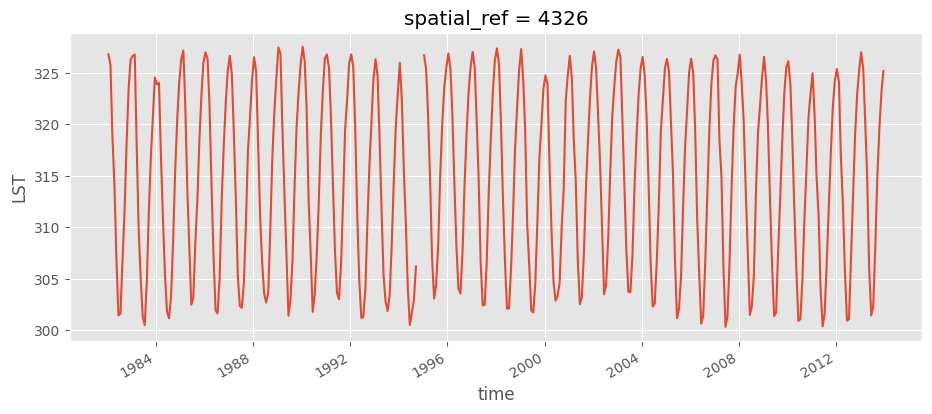

In [51]:
yy[model_var].mean(['latitude', 'longitude']).plot(figsize=(11,4))
# plt.ylim(0.2,0.38)